# Twitter Sentiment Analysis

## Analisis de sentimientos utilizando tweets

Este Notebook contiene la implementación para generar un modelo de análisis de sentimientos
utilizando una red neuronal recurrente de tipo _Long Short Term Memory_ asi como el proceso ETL para 
tokenizar las palabras y adecuar el conjunto de entrenamiento.

A continuación se describen los datos del autor original y se realiza la respectiva referencia.

__Autor:__ Paolo Ripamonti -
[Acerca del autor](https://www.kaggle.com/paoloripamonti)

__Notebook:__ Twitter Sentimental Analysis -
[Notebook original](https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis)

El notebook se modifica con el ánimo de realizar este análisis de sentimientos en el lenguaje español
asi como adecuarlo para escalar apropiadamente para su uso en una arquitectura Big Data

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Geovanny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [4]:
# dataset_filename = os.listdir("../input")[0]
# dataset_path = os.path.join("..","input",dataset_filename)
dataset_path = 'C:/Users/Geovanny/Documents/Repositorios/twitter-bigdata/data/dataset-depurado.csv'
print("Open file:", dataset_path)
#df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS, sep=';')
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, sep=';')

Open file: C:/Users/Geovanny/Documents/Repositorios/twitter-bigdata/data/dataset-depurado.csv


In [5]:
print("Dataset size:", len(df))

Dataset size: 375


In [6]:
df.head(5)

,target,ids,date,user,text
0,0,"1,32654E+18",11/11/2020 15:01,FlechasPaolo,RT SosSemana El 66 de la minera aluvial de oro...
1,0,"1,32654E+18",11/11/2020 14:59,NicolasHC20,RT Rosental Muy grave muy triste la situacin q...
2,0,"1,32654E+18",11/11/2020 14:58,DavidJRicardo1,RT SosSemana El 66 de la minera aluvial de oro...
3,0,"1,32654E+18",11/11/2020 14:57,juanchaves_co,Creer en la ciencia se volvi un tema de partid...
4,0,"1,32654E+18",11/11/2020 14:56,FlorMar81615791,RT SosSemana El 66 de la minera aluvial de oro...


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 950 µs


Text(0.5, 1.0, 'Dataset labels distribuition')

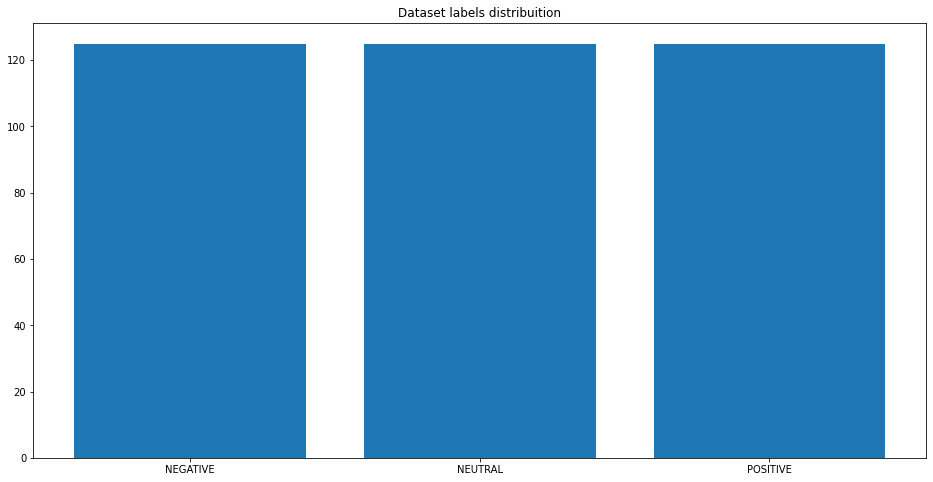

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [10]:
stop_words = stopwords.words("spanish")
stemmer = SnowballStemmer("spanish")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 33.8 ms


### Split train and test

In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 300
TEST size: 75


### Word2Vec 

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 0 ns


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [16]:
w2v_model.build_vocab(documents)

2020-11-11 23:29:04,984 : INFO : collecting all words and their counts
2020-11-11 23:29:04,985 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-11 23:29:04,987 : INFO : collected 1501 word types from a corpus of 3464 raw words and 300 sentences
2020-11-11 23:29:04,988 : INFO : Loading a fresh vocabulary
2020-11-11 23:29:04,989 : INFO : effective_min_count=10 retains 41 unique words (2% of original 1501, drops 1460)
2020-11-11 23:29:04,990 : INFO : effective_min_count=10 leaves 901 word corpus (26% of original 3464, drops 2563)
2020-11-11 23:29:04,992 : INFO : deleting the raw counts dictionary of 1501 items
2020-11-11 23:29:04,993 : INFO : sample=0.001 downsamples 41 most-common words
2020-11-11 23:29:04,994 : INFO : downsampling leaves estimated 201 word corpus (22.4% of prior 901)
2020-11-11 23:29:04,995 : INFO : estimated required memory for 41 words and 300 dimensions: 118900 bytes
2020-11-11 23:29:04,996 : INFO : resetting layer weights


In [17]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 41


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-11-11 23:29:05,144 : INFO : training model with 8 workers on 41 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-11-11 23:29:05,157 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-11 23:29:05,158 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-11 23:29:05,158 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-11 23:29:05,159 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-11 23:29:05,160 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-11 23:29:05,161 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-11 23:29:05,161 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-11 23:29:05,162 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-11 23:29:05,163 : INFO : EPOCH - 1 : training on 3464 raw words (197 effective words) took 0.0s, 26088 effective word

Wall time: 572 ms


(6503, 110848)

In [19]:
#w2v_model.wv.most_similar("Violencia")

### Tokenize Text

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 1502
Wall time: 9 ms


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 7 ms


### Label Encoder 

In [22]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEUTRAL', 'NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [23]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (300, 1)
y_test (75, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (300, 300)
y_train (300, 1)

x_test (75, 300)
y_test (75, 1)


In [25]:
y_train[:10]

array([[1],
       [0],
       [0],
       [2],
       [0],
       [0],
       [2],
       [0],
       [0],
       [0]], dtype=int64)

### Embedding layer

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(1502, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          450600    
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 611,101
Trainable params: 160,501
Non-trainable params: 450,600
_________________________________________________________________


### Compile model

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [31]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1/1 [==============================] - 1s 554ms/step - loss: 0.6936 - accuracy: 0.3370 - val_loss: 0.6764 - val_accuracy: 0.2667
Epoch 2/8
1/1 [==============================] - 0s 156ms/step - loss: 0.6820 - accuracy: 0.3481 - val_loss: 0.6582 - val_accuracy: 0.2667
Epoch 3/8
1/1 [==============================] - 0s 141ms/step - loss: 0.6706 - accuracy: 0.3481 - val_loss: 0.6397 - val_accuracy: 0.2667
Epoch 4/8
1/1 [==============================] - 0s 167ms/step - loss: 0.6591 - accuracy: 0.3481 - val_loss: 0.6202 - val_accuracy: 0.2667
Epoch 5/8
1/1 [==============================] - 0s 144ms/step - loss: 0.6474 - accuracy: 0.3481 - val_loss: 0.5986 - val_accuracy: 0.2667
Epoch 6/8
1/1 [==============================] - 0s 147ms/step - loss: 0.6342 - accuracy: 0.3481 - val_loss: 0.5734 - val_accuracy: 0.2667
Wall time: 31.1 s


### Evaluate

In [32]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 0s 2ms/step - loss: 0.6190 - accuracy: 0.3067

ACCURACY: 0.30666667222976685
LOSS: 0.6190183162689209
Wall time: 482 ms


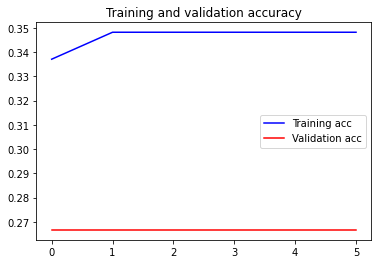

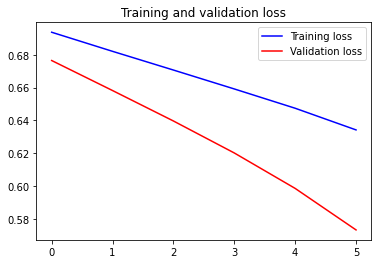

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [34]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [35]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [36]:
predict("Masacre en el cauca deja 10 heridos")

{'label': 'NEUTRAL',
 'score': 0.5317609906196594,
 'elapsed_time': 0.28629326820373535}

In [37]:
predict("Prevencion de la violencia contra la mujer")

{'label': 'NEUTRAL',
 'score': 0.5424326062202454,
 'elapsed_time': 0.09462118148803711}

### Confusion Matrix

In [38]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 0s 0s/step
Wall time: 552 ms


In [39]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

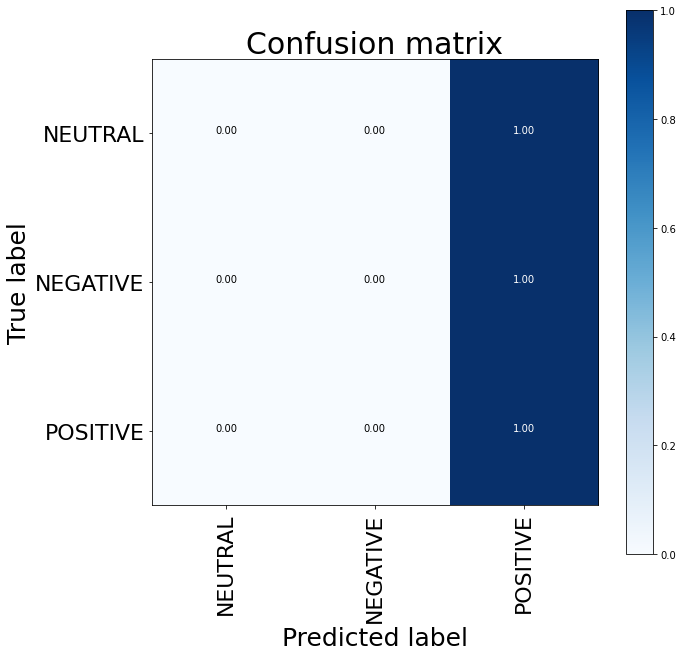

Wall time: 214 ms


In [40]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [41]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00        32
     NEUTRAL       0.00      0.00      0.00        23
    POSITIVE       0.27      1.00      0.42        20

    accuracy                           0.27        75
   macro avg       0.09      0.33      0.14        75
weighted avg       0.07      0.27      0.11        75



C:\Users\Geovanny\.conda\envs\twitter\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Accuracy Score

In [42]:
accuracy_score(y_test_1d, y_pred_1d)

0.26666666666666666

### Save model

In [43]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-11-11 23:29:42,931 : INFO : saving Word2Vec object under model.w2v, separately None
2020-11-11 23:29:42,932 : INFO : not storing attribute vectors_norm
2020-11-11 23:29:42,933 : INFO : not storing attribute cum_table
2020-11-11 23:29:42,989 : INFO : saved model.w2v
